<a href="https://colab.research.google.com/github/Shacham-R/Song_Recommender/blob/main/S_Rotem_Spotipy_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
!pip install spotipy
import spotipy as sp
import sklearn.preprocessing as sk
from sklearn.cluster import KMeans
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt

In [25]:
from spotipy.oauth2 import SpotifyClientCredentials


c_id = 'a5a0d6ee906e4ead819821a17f9ec651'
c_se ='680ffd44ed214055be771972a3495cc4'

sp = sp.Spotify(auth_manager=SpotifyClientCredentials(client_id=c_id, client_secret=c_se))

# Playlist import and DF creation

In [26]:
#getting songs from a playlist
def get_playlist_tracks(playlist_id):
    results = sp.user_playlist_tracks(playlist_id = playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return tracks

In [27]:
#TODO request playlists
def get_playlists(username):
    results = sp.user_playlists('spotify')
    playlists_ids = []
    for playlist in results['items']:
      playlists_ids.append(playlist['id'])
    while results['next']:
        results = sp.next(results)
        for playlist in results['items']:
          playlists_ids.append(playlist['id'])
    return playlists_ids

In [28]:
#playlists_list = ['37i9dQZF1DWTJ7xPn4vNaz','37i9dQZF1DX4o1oenSJRJd','37i9dQZF1DXbTxeAdrVG2l','37i9dQZF1DX4UtSsGT1Sbe','37i9dQZF1DXaKIA8E7WcJj','37i9dQZF1DWSV3Tk4GO2fq']
playlists_list = get_playlists('spotify')


In [29]:
import random
randslice = random.randrange(0,len(playlists_list)-100)
random100 = playlists_list[randslice:randslice+100]
len(random100)

100

In [30]:
playlist_tracks = []
for i in random100:
  results = get_playlist_tracks(i)
  playlist_tracks.extend(results)
len(playlist_tracks)

6675

In [31]:
pl_ids = []
for j in playlist_tracks:
  try:
    pl_ids.append(j['track']['id'])
  except TypeError:
    pass

In [32]:
len(pl_ids)

6674

In [33]:
chunk_size = 100
playlist_chopped = [pl_ids[i:i+chunk_size] for i in range(0,len(pl_ids), 100)]
print("Number of chuncks:",len(playlist_chopped))

Number of chuncks: 67


In [34]:
pl_af_list = []
for i in playlist_chopped:
  pl_af_list.extend(sp.audio_features(i))

In [35]:
df_af = pd.DataFrame(pl_af_list)
df_af.dropna(inplace=True)
df_af.drop_duplicates(inplace=True)
df_af.reindex()
df_af.duplicated().value_counts()

False    5769
dtype: int64

# Model training

In [57]:
#Selecting numerical columns
df_af.drop(columns=['type','uri','track_href','analysis_url','key','mode','time_signature','duration_ms'],inplace=True,errors='ignore')
df_af.head(1)

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id
0,0.675,0.311,-11.959,0.0525,0.93,0.000261,0.102,0.638,97.159,1TrGdXSgiBm8W68D2K1COG


In [58]:
#Scaling the features
X = df_af.drop(columns=['id'])
scaler = sk.StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns = X.columns)
display(X_scaled_df.head(1))

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.714652,-0.774001,-0.252728,-0.183627,1.340798,-0.703375,-0.486102,0.630868,-0.664208


In [59]:
#Clustering
kmeans = KMeans(n_clusters=17, random_state=1234)
kmeans.fit(X_scaled_df)
labels = kmeans.labels_
np.unique(labels)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
      dtype=int32)

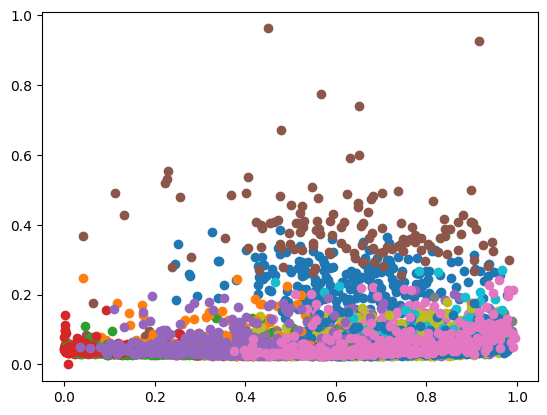

In [60]:
# assign a cluster to each example
labels = kmeans.predict(X_scaled_df)
# retrieve unique clusters
clusters = np.unique(labels)
# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = np.where(labels == cluster)
    # create scatter of these samples
    plt.scatter(X.to_numpy()[row_ix, 1], X.to_numpy()[row_ix, 3])
    # show the plot
plt.show()

In [61]:
clusters = kmeans.predict(X_scaled_df)
#clusters
pd.Series(clusters).value_counts().sort_index()

0     216
1     254
2     473
3     233
4     391
5     397
6     351
7     357
8     600
9     176
10    400
11    324
12    580
13    135
14    425
15    129
16    328
dtype: int64

In [62]:
X["cluster"] = clusters
X.head(1)

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
0,0.675,0.311,-11.959,0.0525,0.93,0.000261,0.102,0.638,97.159,14


# Program Creation

In [63]:
#join DFs after clustering
df = pd.merge(df_af['id'], X,left_index=True,right_index=True)

#df.to_csv('spotipy_df')

In [64]:
#Predicting and returning song ID from the same cluster

In [68]:
#--helper function--
# Getting song name and returning ID (spotipy.search)
def get_song_id(song_name):
  result = sp.search(song_name)
  id_ = result["tracks"]["items"][0]["id"]
  return id_

# Getting prediction
def predict_from_id(id_): # TODO refract!
  af = sp.audio_features(id_)[0]
  af_ = pd.DataFrame(af,index=[0])
  af_ = af_.drop(columns=['id','type','uri','track_href','analysis_url','key','mode','time_signature','duration_ms'],errors='ignore')
  af_ = scaler.fit_transform(af_)
  pred = kmeans.predict(af_)[0]
  recommended = df[df['cluster'] == pred].sample()["id"]
  return recommended.values[0]


from IPython.display import IFrame
def embed_player(track_id):
  return IFrame(src="https://open.spotify.com/embed/track/"+track_id,
        width="320",
        height="80",
        frameborder="0",
        allowtransparency="true",
        allow="encrypted-media",
        )

def name_to_recommendation(song_name):
  id_usr = get_song_id(song_name)
  print("Your song:")
  display(embed_player(id_usr))
  id_rec = predict_from_id(id_usr)
  print('Your song recommendation:')
  display(embed_player(id_rec))

In [66]:
#user input function
def ask_for_song():
  song_name = input('please enter a song name to get a simmilar song recommended to you!\nyou entered: ')
  print('You got back:')
  try:
    return name_to_recommendation(song_name)
  except Exception as error:
    return error

#

In [69]:
ask_for_song()

please enter a song name to get a simmilar song recommended to you!
you entered: macarena
You got back:
Your song:


Your song recommendation:


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
